# Basic engine implementation

#### setup

In [86]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test3.mp4"


[2021-03-17 17:07:18,566] [INFO] [<module>] [14] : Starting ...


#### Detecting the face landmarks and parsing the ROI

In [87]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
#         img = PIL.Image.open(frame)
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.2) # 30 percent of the face len (toadd eyebrow top point).
        # Finding the forehead.
        right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom)) # adding diff to top to make the forehead bigger.

        # Finding the second ROI:
        upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))
#         try:
#             concat_roi_areas = np.concatenate((forehead, nose_to_upper_lip), axis=0)
#             cv2.imwrite('frame_roi_output.jpg', concat_roi_areas)
        return (forehead, nose_to_upper_lip)
#         except:
#             logging.warning("concat of roi areas failed")
#             return None
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [88]:
def bad_frame(blue, green, red):
    if red > 95 and green > 40 and blue > 20 and red >green and red > blue:
        return False
    logging.warning("bad frame detected")
    return True

#### Getting RGB values from a frame and adding them to arrays

In [89]:
def parse_RGB(image, greens, reds, blues, frame_number):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    im = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # inorder to use cv2.split() we need to address the image as BGR (instead of RGB)
    blue, green, red = cv2.split(im)
    b_mean,g_mean,r_mean = np.mean(blue),np.mean(green),np.mean(red)
    if not bad_frame(b_mean,g_mean,r_mean):
        blues = np.append(blues,b_mean)
        greens = np.append(greens,g_mean)
        reds = np.append(reds,r_mean)
#     if not bad_frame(np.mean(blue), np.mean(green), np.mean(red)):
#         greens[0, frame_number] = np.mean(green)
#         blues[0, frame_number] = np.mean(blue)
#         reds[0, frame_number] = np.mean(red)
        return True,greens,reds,blues
    return False,greens,reds,blues 

In [90]:
def get_new_frame(vidcap):
    success, image = vidcap.read()
    return success, image

#### Plotting RGB arrays results

In [91]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [92]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Main loop - going over all the frames of the video

In [93]:
from sklearn.decomposition import FastICA
def getHeartRate(window, lastHR):
    # Normalize across the window to have zero-mean and unit variance
    mean = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    normalized = (window - mean) / std
    print(normalized)
    # Separate into three source signals using ICA
    ica = FastICA()
    srcSig = ica.fit_transform(normalized)

    # Find power spectrum
    powerSpec = np.abs(np.fft.fft(srcSig, axis=0))**2
    freqs = np.fft.fftfreq(window_size, 1.0 / round_fps)

    # Find heart rate
    maxPwrSrc = np.max(powerSpec, axis=1)
    validIdx = np.where((freqs >= 0.75) & (freqs <= 4))
    validPwr = maxPwrSrc[validIdx]
    validFreqs = freqs[validIdx]
    maxPwrIdx = np.argmax(validPwr)
    hr = validFreqs[maxPwrIdx]
    print(hr)

    #plotSignals(normalized, "Normalized color intensity")
    #plotSignals(srcSig, "Source signal strength")
    #plotSpectrum(freqs, powerSpec)

    return hr

[2021-03-17 17:07:18,729] [INFO] [<module>] [3] : Working on video ..\dataset\good_sync\perry-all-2\test3.mp4
[2021-03-17 17:07:18,783] [INFO] [<module>] [13] : Parsing images ...
[2021-03-17 17:07:18,784] [INFO] [<module>] [15] : parsing frame 0/171.0
[2021-03-17 17:07:20,010] [INFO] [<module>] [15] : parsing frame 1/171.0
[2021-03-17 17:07:21,161] [INFO] [<module>] [15] : parsing frame 2/171.0
[2021-03-17 17:07:22,321] [INFO] [<module>] [15] : parsing frame 3/171.0
[2021-03-17 17:07:23,628] [INFO] [<module>] [15] : parsing frame 4/171.0
[2021-03-17 17:07:24,757] [INFO] [<module>] [15] : parsing frame 5/171.0
[2021-03-17 17:07:25,881] [INFO] [<module>] [15] : parsing frame 6/171.0
[2021-03-17 17:07:27,010] [INFO] [<module>] [15] : parsing frame 7/171.0
[2021-03-17 17:07:28,143] [INFO] [<module>] [15] : parsing frame 8/171.0
[2021-03-17 17:07:29,284] [INFO] [<module>] [15] : parsing frame 9/171.0
[2021-03-17 17:07:30,514] [INFO] [<module>] [15] : parsing frame 10/171.0
[2021-03-17 17:0

ValueError: x and y must have same first dimension, but have shapes (171,) and (1, 171)

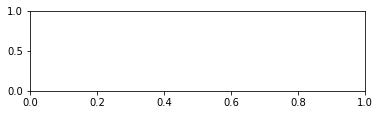

In [94]:
# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
window_size = 30
greens,reds,blues = [],[],[]
frame_number = 0
heart_rates = []
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(frame_number) + "/" + str(number_of_frames))
    # im.save("your_file.jpeg")
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
#     image = cv2.imread("frame_roi_output.jpg") # possible BUG: read the same image twice if face not detected.(FIXED)
        roi = np.vstack((rois[0],rois[1]))
        is_good_frame,greens,reds,blues = parse_RGB(roi, greens, reds, blues, frame_number)
    if is_good_frame:
        frame_number += 1
    success, image = get_new_frame(vidcap)

greens = greens.reshape(-1, greens.shape[-1])
size = 171
while len(greens) > 30 :
    window_start = size - window_size
    size -= window_size
    print("window_start: " + str(window_start) + " , size: " + str(size))
    window = greens[window_start : window_start + window_size]
    last_hr = heart_rates[-1] if len(heart_rates) > 0 else None
    heart_rates.append(getHeartRate(window, last_hr))

if frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'


In [ ]:
#flattop
# Welch method:
f, Pxx_den = sig.welch(green_buttered, round_fps,'hamming', 1024, scaling='spectrum')

### Plot final results

In [ ]:
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
# periodogram method:
f, Pxx_den = sig.periodogram(green_buttered, round_fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()